In [1]:
import numpy as np, numpy.random as npr, torch.nn as nn, copy, timeit, torch
from torch.distributions.bernoulli import Bernoulli 
from HMCfunctions import *
from time import time
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import plot, show, legend

Gradient w.r.t. $\theta$:

$$
\nabla_\theta \log p(\theta \mid \sigma, x_{1:n}, y_{1:n}) 
= 
- \sum_{i=1}^n \frac{\left ( \mu_\theta(x_i) - y_i \right ) \, \nabla_\theta \mu_\theta(x_i) }{\sigma^{2k}} + \nabla_\theta \log p_0(\theta) 
$$

#### Set up neural network:

In [2]:
n_in = 1
# n_h1 = 5
# n_h2 = 10
n_out = 2

nn_model = nn.Sequential(nn.Linear(n_in, n_out))

* Total number of parameters:

In [3]:
print(sum(p.numel() for p in nn_model.parameters()))

4


* Randomly initialise model parameters:

In [4]:
nn_model.apply(init_normal)

Sequential(
  (0): Linear(in_features=1, out_features=2, bias=True)
)

#### Generate some random data:

In [5]:
nobs = 10_000
x = torch.rand(nobs, n_in)
y = np.zeros((nobs, n_out))
y[:,0] = list(np.cos(2*np.pi*x))
y[:,1] = list(np.sin(2*np.pi*x))
y = torch.from_numpy(y).float()
criterion = nn.MSELoss()

* Get dimensions of parameters:

In [6]:
shapes = get_shapes(nn_model)
print("Shapes = ", shapes)

Shapes =  [torch.Size([2, 1]), torch.Size([2])]


###  HMC

* First define the MCMC chain and randomly initialise it:

In [7]:
T = 2_000
chain = []
for shape in shapes :
    chain_shape = list(shape)
    chain_shape.insert(0,T)
    chain.append(torch.randn(chain_shape, requires_grad=False))

* Then run HMC:

In [16]:
delta_leapfrog = 1e-1
n_leapfrog = 10
prior_sigma = 1
error_sigma = 1
nn_model.apply(init_normal)
n_accept = 0

In [17]:
start_time = time()
for t in range(T) : 
    nn_model, a = HMC_1step(nn_model, n_leapfrog, delta_leapfrog, shapes, x, y, criterion, prior_sigma)
    n_accept += a
    update_grads(nn_model, x, y)
    for (i,param) in enumerate(nn_model.parameters()) :
        chain[i][t] = param.data
        
    if ((t+1) % 200 == 0) or (t+1) == T :
        accept_rate = float(n_accept) / float(t+1)
        print("iter %6d/%d after %7.1f sec | accept_rate %.3f" % (
            t+1, T, time() - start_time, accept_rate))

iter    200/2000 after     1.2 sec | accept_rate 0.575
iter    400/2000 after     2.5 sec | accept_rate 0.565
iter    600/2000 after     3.8 sec | accept_rate 0.552
iter    800/2000 after     5.1 sec | accept_rate 0.547
iter   1000/2000 after     6.4 sec | accept_rate 0.542
iter   1200/2000 after     7.6 sec | accept_rate 0.540
iter   1400/2000 after     8.9 sec | accept_rate 0.536
iter   1600/2000 after    10.2 sec | accept_rate 0.538
iter   1800/2000 after    11.4 sec | accept_rate 0.541
iter   2000/2000 after    12.7 sec | accept_rate 0.534


#### ESS's:

In [18]:
ESS, means, Vars = find_ESS(chain, shapes)

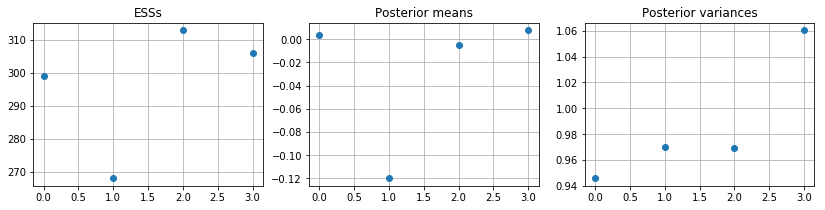

In [19]:
plt.figure(figsize=(14,3))
plt.rcParams['axes.grid'] = True
plt.subplot(131)
plt.plot(ESS, 'o', markersize=6)
plt.title("ESSs")
plt.subplot(132)
plt.plot(means, 'o', markersize=6)
plt.title("Posterior means")
plt.subplot(133)
plt.plot(Vars, 'o', markersize=6)
plt.title("Posterior variances");

* There is some bug, because the posterior seems to be basically the prior. Increasing the number of data points does not seem to make any difference, only the prior variance makes a difference. 

#### Some diagnostics:

In [29]:
for param in nn_model.parameters() :
    print(param.data)

tensor([[ 0.0568],
        [ 0.0717],
        [-0.1660],
        [ 0.1499],
        [ 0.0217]])
tensor([-0.0147, -0.1183,  0.1159,  0.2373,  0.0040])
tensor([[ 0.0592,  0.2783,  0.1133,  0.1754, -0.0465],
        [ 0.0093,  0.1470,  0.1040,  0.0175,  0.0557]])
tensor([ 0.2440, -0.0011])


In [36]:
mom = generate_momentum(shapes)
for (i, param) in enumerate(nn_model.parameters()) :
    print(param.grad)
    pos_change = delta_leapfrog*mom[i]
    param.data.add_(pos_change)

# update gradients based on new parameters (ie, new positions):
update_grads(nn_model, x, y)

tensor([[-0.0017],
        [ 0.1198],
        [-0.0413],
        [ 0.0180],
        [-0.0067]])
tensor([-0.0475,  0.0733, -0.0388,  0.0092,  0.0024])
tensor([[-0.1010,  0.0318, -0.0577,  0.1639, -0.0535],
        [ 0.0624,  0.0261, -0.0146, -0.1096,  0.0899]])
tensor([ 0.3493, -0.2647])


In [38]:
for param in nn_model.parameters() :
    print(param.grad, param.data)

tensor([[-0.0321],
        [ 0.1064],
        [-0.0384],
        [ 0.0445],
        [-0.0029]]) tensor([[-0.0915],
        [ 0.2873],
        [-0.3784],
        [ 0.0881],
        [ 0.2455]])
tensor([-0.1525,  0.0253, -0.0561,  0.0568, -0.0123]) tensor([-0.1196,  0.0579,  0.0866,  0.4649, -0.1564])
tensor([[-0.0682,  0.0867, -0.0500,  0.1908, -0.0080],
        [ 0.0589, -0.0412, -0.0202, -0.2018,  0.0588]]) tensor([[-0.0858,  0.6051, -0.1807,  0.2724, -0.0085],
        [ 0.2646,  0.4574, -0.0350,  0.0774,  0.0197]])
tensor([ 0.4032, -0.4566]) tensor([ 0.1545, -0.5320])


### SGD:

In [50]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(nn_model.parameters(), lr=0.01)

In [52]:
for epoch in range(10_000):
    # Forward Propagation
    y_pred = nn_model(x)
    # Compute and print loss
    loss = criterion(y_pred, y)
    if (epoch+1)%1_000 == 0 :
        print('epoch: ', epoch+1,' loss: ', loss.item())
    # Zero the gradients
    optimizer.zero_grad()
    
    # perform a backward pass (backpropagation)
    loss.backward()
    
    # Update the parameters
    optimizer.step()

epoch:  1000  loss:  0.0023619267158210278
epoch:  2000  loss:  0.002133300295099616
epoch:  3000  loss:  0.0019551068544387817
epoch:  4000  loss:  0.0018106142524629831
epoch:  5000  loss:  0.0016899053007364273
epoch:  6000  loss:  0.0015869464259594679
epoch:  7000  loss:  0.0014977598330006003
epoch:  8000  loss:  0.0014195973053574562
epoch:  9000  loss:  0.0013503892114385962
epoch:  10000  loss:  0.0012886177282780409
